In [1]:
from PIL import Image
from torchvision import transforms, datasets

import numpy as np
from matplotlib import pyplot as plt
import math

from tqdm import tqdm
from datetime import datetime

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.transforms import v2

from torch.utils.tensorboard import SummaryWriter

'''
    WARNING: check experiment number!!!
'''
EXPERIMENT_NUMBER = 4

### Loading model

In [3]:
norm = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [4]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("DEVICE:", device)
model.to(device)
model.eval()

DEVICE: cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Focal loss definition

In [5]:
class FocalLoss(torch.nn.Module):
        '''
        Multi-class Focal loss implementation
        '''

        def __init__(self, gamma=2, weight=None):
            super(FocalLoss, self).__init__()
            self.gamma = gamma
            self.weight = weight

        def forward(self, inp, target):
            """
            input: [N, C]
            target: [N, ]
            """
            logpt = torch.nn.functional.log_softmax(inp, dim=1)
            pt = torch.exp(logpt)
            logpt = ((1 - pt) ** self.gamma) * logpt
            loss = torch.nn.functional.nll_loss(logpt, target, self.weight)
            return loss

### Masks

In [6]:
class MaskImageAll(nn.Module):
    def __init__(self, class_ind, count_classes):
        super(MaskImageAll, self).__init__()
        self.class_ind = class_ind
        self.count_classes = count_classes

    def forward(self, image):
        c, h, w = image.shape

        num_columns = int(math.ceil(math.sqrt(self.count_classes)))
        num_rows = int(math.ceil(self.count_classes / float(num_columns)))

        tile_w, tile_h = int(math.floor(w / num_columns)), int(math.floor(h / num_rows))


        row = self.class_ind // num_columns
        column = self.class_ind % num_columns

        mask = torch.ones_like(image)  # maybe add requires_grad = Ture
        mask[:, row * tile_h: (row + 1) * tile_h, column * tile_w: (column + 1) * tile_w] = torch.zeros([3, tile_h, tile_w])

        return image * mask

In [7]:
class MaskLine(nn.Module):
    def __init__(self, class_ind, count_classes, axis=0):
        super(MaskLine, self).__init__()
        self.class_ind = class_ind
        self.count_classes = count_classes
        self.axis = axis

    def forward(self, image):
        c, h, w = image.shape

        mask = torch.ones_like(image)

        if self.axis == 0:
            interval = h // self.count_classes
            mask[:, self.class_ind * interval: (self.class_ind + 1) * interval, :] = torch.zeros([3, interval, w])
        elif self.axis == 1:
            interval = w // self.count_classes
            mask[:, :, self.class_ind * interval: (self.class_ind + 1) * interval] = torch.zeros([3, h, interval])

        return image * mask

### Loading dataset cifar-10 just for visualizating

In [8]:
trainset = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transforms.ToTensor())
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


### Visualizating Masks

Text(0.5, 1.0, 'With hidden horizontal line')

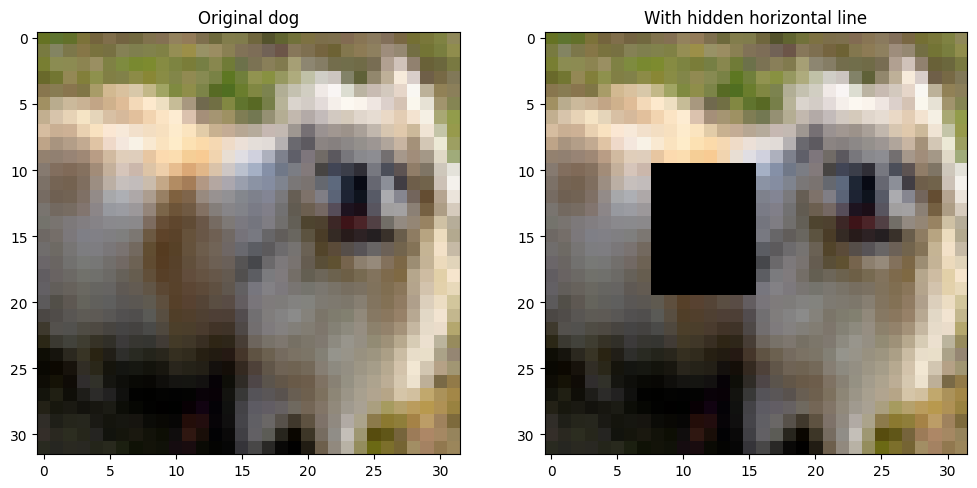

In [10]:
index = 40
test_image = trainset[index][0]
label = trainset[index][1]
f, axs = plt.subplots(1,2, figsize=(12, 8))
axs[0].imshow(test_image.permute(1, 2, 0))
axs[0].set_title(f"Original {classes[label]}")
# axs[1].imshow(mask_part(test_image.unsqueeze(0), label, 10).squeeze().permute(1, 2, 0))
axs[1].imshow(MaskImageAll(label, 10)(test_image).permute(1, 2, 0))
axs[1].set_title(f"With hidden horizontal line")


### Training

In [96]:
def get_accuracy(model, univ_image, num_classes, mask):
    with torch.no_grad():
        probs = []
        k = 0
        for label in range(num_classes):
            masked = mask(label, num_classes)(univ_image).unsqueeze(0)
            preds = model(norm(masked))
            prob, pred_label = torch.nn.Softmax(dim=1)(preds).max(1)
            if pred_label[0] == label:
                k += 1
            probs.append(prob[0].cpu().detach().numpy())

        return k, probs


In [142]:
def train(model, univ_image, epochs, batch_size, num_classes, criterion, mask, writer=None) -> torch.Tensor:
    opt = optim.SGD([univ_image], lr=1e-1)
    # criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.3, patience=250, min_lr=1e-4, threshold=1e-4)
    cur_class = 0
    start_time = datetime.now()
    for t in range(epochs):
        
        
        batch = []
        labels = []
        for k in range(batch_size):
            batch.append(mask(cur_class, num_classes)(univ_image).to(device))
            labels.append(cur_class)
            cur_class = (cur_class + 1) % num_classes
        batch = torch.stack(batch, dim=0).to(device)
        labels = torch.LongTensor(labels).to(device)
        

        preds = model(norm(batch))
        loss = criterion(preds, labels)

        opt.zero_grad()
        loss.backward()
        opt.step()
        
        acc, probs = get_accuracy(model, univ_image, num_classes, mask)
        if t % (epochs // 20) == 0:
            # print(preds.shape, labels.shape)
            
            delta = datetime.now() - start_time
            start_time = datetime.now()
            
            print(f"EPOCH = {t}/{epochs} | loss = {loss.item()} | acc={acc / num_classes} | lr={scheduler.optimizer.param_groups[0]['lr']} | time={int(delta.total_seconds() // 60)}:{delta.seconds % 60}")
            writer.add_scalar(f'Acc', acc / num_classes, t)
        
        if writer is not None:
            writer.add_scalar(f'Loss', loss.item(), t)
            writer.add_scalar(f'LR', scheduler.optimizer.param_groups[0]['lr'], t)
            writer.flush()
        
        scheduler.step(loss.item())

        univ_image.data.clamp_(0, 1)
    return univ_image

In [143]:
NUM_CLASSES =  64
BATCH_SIZE = 64  
IMAGE_SIZE = 64
EPOCHS = 5000
MASK = MaskLine
# CRITERION = FocalLoss(gamma=1) 
CRITERION = nn.CrossEntropyLoss()


univ_image = torch.randn(size=(3, IMAGE_SIZE, IMAGE_SIZE), requires_grad=True, device=device)

writer = SummaryWriter(f"runs/experiment {EXPERIMENT_NUMBER}", comment=f"{NUM_CLASSES=}\n{BATCH_SIZE=}\n{IMAGE_SIZE=}\n{EPOCHS=}\n{MASK.__name__=}\n{CRITERION.__class__.__name__=}")
print(f"Running experiment {EXPERIMENT_NUMBER=}")

univ_image = train(
    model=model,
    univ_image=univ_image,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    num_classes=NUM_CLASSES,
    criterion=CRITERION,
    mask=MASK,
    writer=writer
)
writer.flush()
writer.close()
EXPERIMENT_NUMBER += 1

Running experiment EXPERIMENT_NUMBER=11
EPOCH = 0/5000 | loss = 20.360116958618164 | acc=0.0 | lr=0.1 | time=0:0
EPOCH = 250/5000 | loss = 2.6102426052093506 | acc=0.390625 | lr=0.1 | time=2:27
EPOCH = 500/5000 | loss = 1.6477136611938477 | acc=0.609375 | lr=0.1 | time=2:23
EPOCH = 750/5000 | loss = 1.4307962656021118 | acc=0.65625 | lr=0.1 | time=2:25
EPOCH = 1000/5000 | loss = 1.1719675064086914 | acc=0.75 | lr=0.1 | time=2:31
EPOCH = 1250/5000 | loss = 1.0515857934951782 | acc=0.8125 | lr=0.1 | time=2:33
EPOCH = 1500/5000 | loss = 0.9483609199523926 | acc=0.828125 | lr=0.1 | time=2:34
EPOCH = 1750/5000 | loss = 0.8226281404495239 | acc=0.875 | lr=0.1 | time=2:33
EPOCH = 2000/5000 | loss = 0.7940095067024231 | acc=0.890625 | lr=0.1 | time=2:31
EPOCH = 2250/5000 | loss = 0.6754928231239319 | acc=0.875 | lr=0.1 | time=2:32
EPOCH = 2500/5000 | loss = 0.6185108423233032 | acc=0.890625 | lr=0.1 | time=2:31
EPOCH = 2750/5000 | loss = 0.6627371311187744 | acc=0.921875 | lr=0.1 | time=2:40
E

In [144]:
acc, probs = get_accuracy(model, univ_image, NUM_CLASSES, MASK)
acc / NUM_CLASSES

1.0

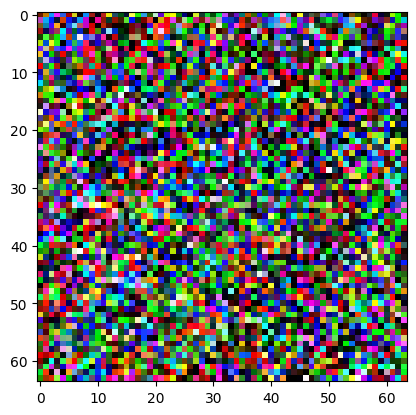

In [145]:
plt.imshow((univ_image.permute(1, 2, 0).cpu().detach().numpy() * 255).astype(np.uint8))

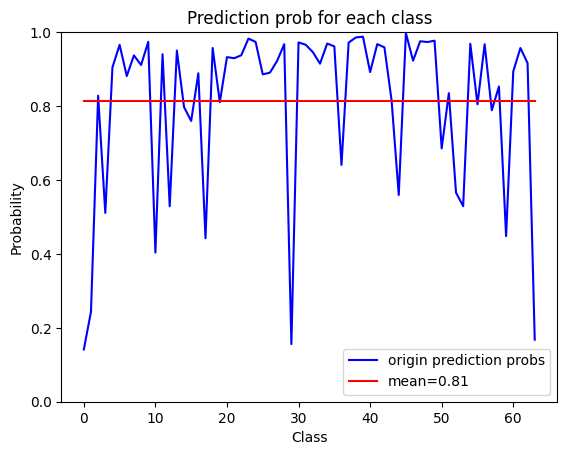

In [146]:
plt.plot(np.arange(NUM_CLASSES), probs, label="origin prediction probs", color="blue")
plt.plot(np.arange(NUM_CLASSES), [sum(probs) / NUM_CLASSES] * NUM_CLASSES, label="mean={:.2f}".format(sum(probs) / NUM_CLASSES), color="red")
plt.xlabel('Class')
plt.ylabel("Probability")
plt.title("Prediction prob for each class")
ax = plt.gca()
ax.set_ylim([0, 1])
plt.legend()
plt.show()